In [1]:
%run setup.py

In [2]:
# rv_jd, rv_rv, rv_err = np.loadtxt('../../data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
# rv_jd += 2400000
# rv_jd -= 2454833

In [3]:
# t, y = lc.time, lc.flux
time, mag = np.loadtxt('../../data/kic6780873_lc.txt', usecols=(0,1)).T
time += 2400000
time -= 2454833
time, mag = time, mag*1e3

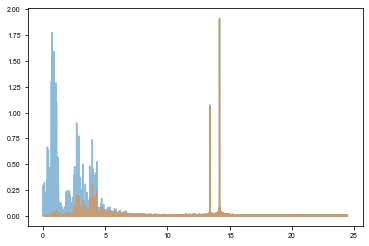

In [4]:
from scipy.ndimage import gaussian_filter
from maelstrom.utils import amplitude_spectrum
y_low = gaussian_filter(mag,2)
y_high = mag - y_low

plt.plot(*amplitude_spectrum(time, mag), alpha=0.5)
plt.plot(*amplitude_spectrum(time, y_high), alpha=0.5)

In [5]:
mag = y_high

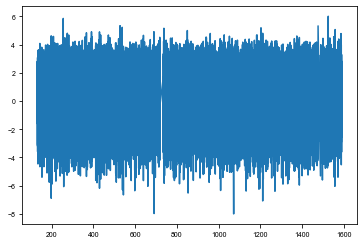

In [6]:
plt.plot(time, mag)

In [7]:
freq = np.array([14.18764198, 13.43633836])

In [11]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

rv = False

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0, upper=12)("P", mu=9.159153, sd=1,
                                     shape=1, testval=9.159153)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=0, upper=25)("logasini", mu=np.log(17.441530), sd=5,
                                        shape=1, testval=np.log(17.441530))
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(mag)), sd=10, testval=0.)
    asini = pm.Deterministic('asini', tt.exp(logasini))
#     logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.27)
    omega = xo.distributions.Angle("omega", testval=2.306092)
    phi = xo.distributions.Angle('phi', testval=0.377081)
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    
    # LIGHTCURVE
    M = 2. * np.pi * time / P - phi
    f = get_true_anomaly(M, ecc + tt.zeros_like(M))
    psi = -((1 - tt.square(ecc)) * tt.sin(f+omega) / (1 + ecc*tt.cos(f)))
    tau = (asini / 86400.) * psi[:, None]
    arg = 2. * np.pi * nu * (time[:, None] - tau)
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, mag))
    lc_model = tt.dot(D, w)
    full_lc = lc_model
    
#     logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=100)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
#     gp_l = gp.log_likelihood(mag - full_lc)
#     # Weight likelihood equally with RV data
#     pm.Potential("obs", gp_l#/ (len(time) / len(rv_jd))
#                 )
    
#     pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=mag)
    
    if rv:
        
        gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=0.)
        logs_rv = pm.Normal('logs_rv', mu=np.log(np.std(rv_rv)), sd=10, testval=np.log(np.std(rv_rv)))

        M_RV = 2. * np.pi * rv_jd / P - phi
        # True anom
        f_RV = get_true_anomaly(M_RV, ecc + tt.zeros_like(M_RV))
        vrad = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f_RV + omega) + ecc*tt.cos(omega))
        vrad *= 299792.458  # c in km/s
        vrad += gammav # Systemic velocity

        err = tt.sqrt(2*rv_err**2 + tt.exp(2*logs_rv))
        pm.Normal("obs_rv", mu=vrad, sd=err, observed=rv_rv)

        plt.plot(rv_jd, xo.eval_in_model(vrad))
        plt.scatter(rv_jd, rv_rv)
    
    
# t = np.linspace(x.min()-5, x.max()+5, 1000)
# with model:
#     M2 = 2. * np.pi * t / P - phi
#     f2 = get_true_anomaly(M2, ecc + tt.zeros_like(M2))
#     vrad2 = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f2 + omega) + ecc*tt.cos(omega))
#     vrad2 *= 299792.458  # c in km/s|
#     vrad2 += gammav # Systemic velocity
#     pm.Deterministic("vrad_pred", vrad2)

In [12]:
with model:
    trace = pm.load_trace('KIC 6780873/join_trace_X_NO_RV_NO_GP_FILTERED/')

In [13]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-0.156468,2.813720e-03,4.697574e-05,-0.161928,-0.151083,3776.008914,0.999900
lognu__0,2.652371,6.727961e-08,1.226122e-09,2.652371,2.652371,3507.744240,1.000156
lognu__1,2.597963,1.268105e-07,2.165751e-09,2.597963,2.597963,3622.213418,0.999873
P__0,9.159407,5.684668e-03,1.623445e-04,9.148282,9.170514,1348.442844,1.001862
logasini__0,2.953600,2.839364e-01,9.728243e-03,2.407533,3.537732,840.282250,1.000307
asini__0,20.016055,6.656693e+00,2.861584e-01,9.708742,31.236614,537.836715,1.000928
ecc__0,0.463057,2.710897e-01,7.031460e-03,0.002109,0.927370,1527.410134,1.000670
omega,0.744087,1.160879e+00,4.163344e-02,-1.587516,3.128220,736.452236,1.002252
phi,-0.759148,1.168287e+00,3.078391e-02,-3.134444,1.921870,1176.935070,1.001607
nu__0,14.187642,9.545390e-07,1.739578e-08,14.187640,14.187643,3507.744189,1.000156


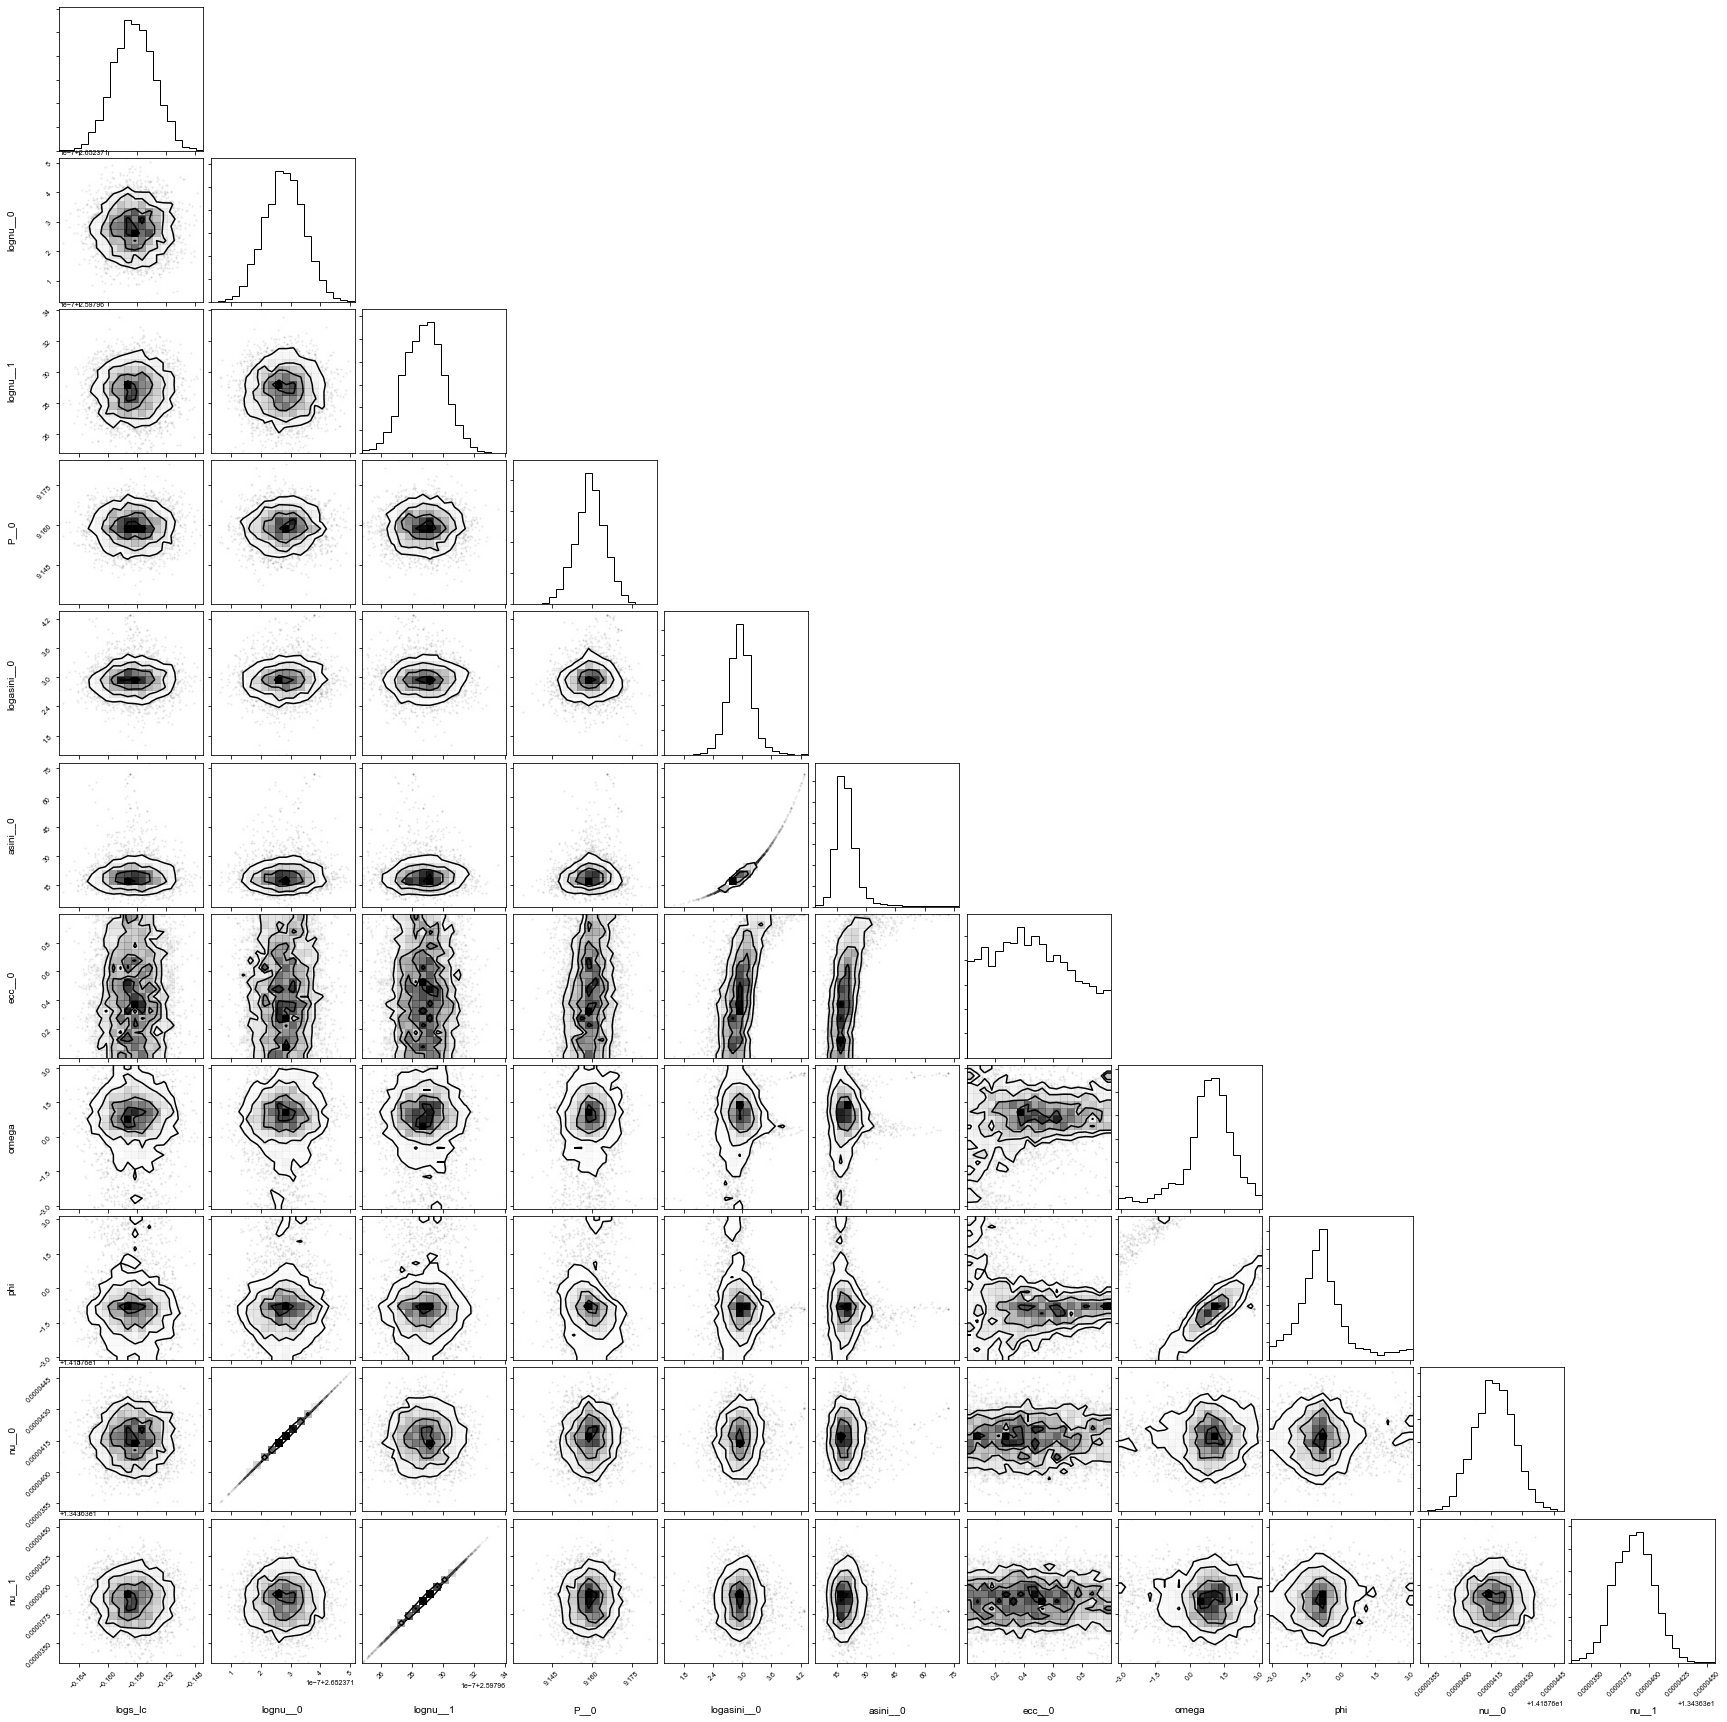

In [14]:
import corner
corner.corner(pm.trace_to_dataframe(trace));

In [17]:
varnames=['P', 'phi', 'ecc', 'asini', 'omega']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(f"{varname}: {med:.3f}+{(upper-med):.3f}-{(med-lower):.3f}")
#     print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

P: 9.160+0.002-0.002
phi: -0.738+0.225-0.232
ecc: 0.579+0.141-0.120
asini: 19.910+2.097-1.689
omega: 1.230+0.270-0.284


In [25]:
np.mod(-1.2, 1)

0.8

In [21]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['P', 'asini'])
mfs = mass_function(samples['P__0'].values * u.day, samples['asini__0'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.101  +  0.035  -  0.024


In [9]:
with model:
    if rv:
#         map_soln = xo.optimize(start=model.test_point)
        map_soln = xo.optimize(start=model.test_point, vars=[gammav])
        map_soln = xo.optimize(start=map_soln, vars=[phi])
    
    all_but = [v for v in model.vars if v.name not in ["P_interval__"]]
    map_params = xo.optimize(start=None, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[ecc, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params,
                             vars=all_but
                            )

    map_params = xo.optimize(start=map_params, vars=[P])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    

optimizing logp for variables: [logs_lc]
9it [00:00,  9.99it/s, logp=-8.186763e+04]
message: Optimization terminated successfully.
logp: -83300.16025996838 -> -81867.63020432253
optimizing logp for variables: [omega, ecc]
12it [00:00, 29.52it/s, logp=-8.184710e+04]
message: Optimization terminated successfully.
logp: -81867.63020432253 -> -81847.09611188417
optimizing logp for variables: [phi]
240it [00:06, 35.03it/s, logp=-8.182660e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -81847.09611188417 -> -81826.6016871801
optimizing logp for variables: [lognu]
68it [00:01, 34.78it/s, logp=-8.182652e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -81826.6016871801 -> -81826.52234321294
optimizing logp for variables: [lognu, phi, omega, ecc, logs_lc, logasini]
105it [00:03, 29.47it/s, logp=-8.182443e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -81826.52234321294 -> -81824.43091276941
opt

In [10]:
map_params


{'P_interval__': array([1.17071016]),
 'logasini_interval__': array([-1.97517164]),
 'logs_lc': array(-0.15641435),
 'ecc_logodds__': array([0.16504164]),
 'omega_angle__': array([3.54822986, 2.72214341]),
 'phi_angle__': array([-3.74638859,  2.4422474 ]),
 'lognu': array([2.65237128, 2.59796288]),
 'P': array([9.15928028]),
 'logasini': array([3.04586213]),
 'asini': array([21.02815236]),
 'ecc': array([0.54116701]),
 'omega': array(0.91638817),
 'phi': array(-0.99309096),
 'nu': array([14.18764164, 13.43633869])}

In [12]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.9), start=map_params
    )

Only 5 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs_rv, gammav, logpower, logw0, lognu, phi, omega, ecc, logs, logs_lc, logasini, P]
Sampling 2 chains: 100%|██████████| 20/20 [00:01<00:00, 15.22draws/s]
/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.


In [16]:
pm.save_trace(trace,'KIC 6780873/join_trace_X')

'KIC 6780873/join_trace'

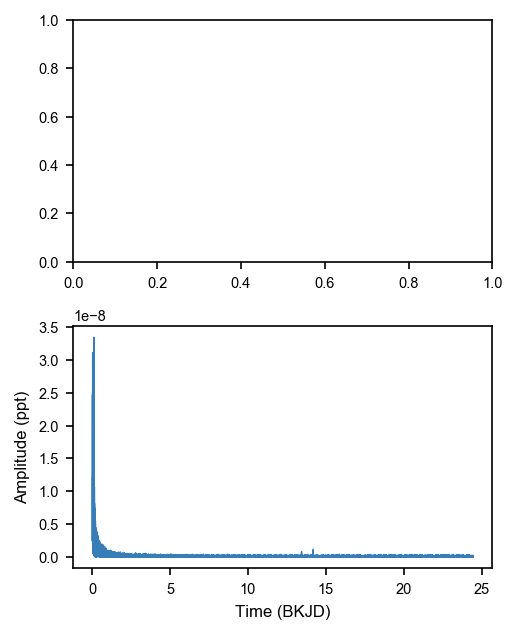

In [32]:
from maelstrom.utils import amplitude_spectrum
from maelstrom.utils import unique_colors

fig, axes = plt.subplots(2,1, figsize=[3.33333, 2.06*2], constrained_layout=True)

with model:
    ax = axes[1]
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)), c=blue, alpha=1, linewidth=0.7)
#     ax.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)), c=orange, alpha=1, linewidth=0.7)
    ax.set_xlabel('Time (BKJD)')
    ax.set_ylabel('Amplitude (ppt)')